In [1]:

import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.stats import skew
import numpy as np
from scipy.cluster import hierarchy
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from pathlib import Path
import matplotlib.patches as mpatches

sys.path.append('../../../')

from src.emotion.prediction.aggregates.train import HyperparaSearch
from src.emotion.prediction.aggregates.models import MODELS
from src.emotion.prediction.aggregates.test import load_models, generate_predictions, plot_predictions
from src.emotion.utils.constants import DATA_DIR

%matplotlib inline
plt.style.use('ggplot')

# set default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#77b5e5', '#e46c81', '#97d2c5', '#e696cc', '#b6b6b6', '#a980b8', '#e9d66b'])

In [2]:
features = pd.read_csv('/home/moritz/Workspace/masterthesis/data/features_dataset_big.csv')

In [3]:
targets = pd.read_csv('/home/moritz/Workspace/masterthesis/data/perma_scores_dataset.csv')

In [4]:
df = pd.merge(features, targets, on=["E-Mail-Adresse", "Day"])

df.shape

(103, 9351)

In [5]:
# Handle Missing Values

df.dropna(axis=1, how='any', inplace=True)
#df = dataset.loc[:, (df != 0).any(axis=0)]

print(df.shape)


(103, 9348)


In [6]:
# Detect outliers
# find columns where all values are the same
cols_to_drop = [col for col in df.columns if df[col].nunique() == 1]
# drop the columns
df = df.drop(cols_to_drop, axis=1)
print(df.shape)

# drop columns where all values are only 0 or 1
df = df.loc[:, ~(df.isin([0, 1]).all() & ~df.isin([0, 1]).any())]
print(df.shape)

(103, 8757)
(103, 8757)


In [7]:
# Load X and Y
# Store the PERMA values in Y
Y = df[['P', 'E', 'R', 'M', 'A']]

# Store the other columns in X
X = df.drop(columns=['ClassID', 'E-Mail-Adresse', 'Day', 'First Name', 'Last Name/Surname', 'P', 'E', 'R', 'M', 'A'])

In [8]:
# Scale Features
# Create a MinMaxScaler object
minmax_scaler = MinMaxScaler()
gaussian_scaler = StandardScaler()
non_gaussian_scaler = RobustScaler()

# Calculate skewness of each feature
skewness = skew(X, axis=0)

# Create empty list to store scaled features
scaled_features = []

# Scale features using appropriate scaler
for feat, s in zip(X.columns, skewness):
    if abs(s) < 0.5:
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    scaled_feat = scaler.fit_transform(X[feat].values.reshape(-1, 1)).flatten()
    scaled_features.append(pd.Series(scaled_feat, name=feat))

# Concatenate scaled features into new DataFrame
scaled_X = pd.concat(scaled_features, axis=1)


# Fit the scaler to the dataframe and transform the dataframe
Y = pd.DataFrame(minmax_scaler.fit_transform(Y), columns=['P', 'E', 'R', 'M', 'A'])


/tmp/ipykernel_772271/2702923847.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(X, axis=0)


In [9]:
X.shape

(103, 8747)

In [10]:
corr_matrix = X.corr()

In [11]:
def plot_correlation_matrix(matrix):
    # center the matrix
    matrix = matrix - np.mean(matrix, axis=0)

    # transpose the matrix
    matrix_t = matrix.T

    # compute the correlation matrix using np.corrcoef
    corr_matrix = np.corrcoef(matrix_t)

    # create a heatmap of the correlation matrix using seaborn
    sns.set(font_scale=0.7)
    sns.heatmap(corr_matrix, cmap="YlGnBu")

In [12]:
#plot_correlation_matrix(X)

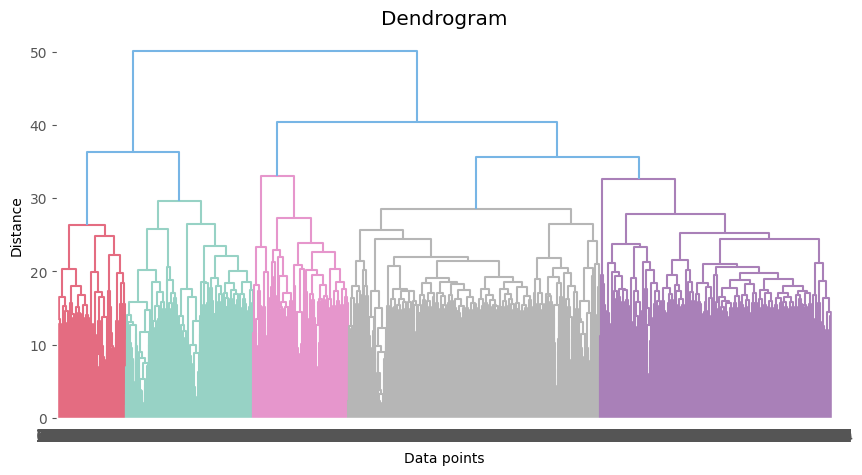

In [13]:
# Feature selection: runs in ~ 5min 
# Step 1: Identify feature clusters
# Create a dendrogram using hierarchical clustering
linkage = hierarchy.linkage(corr_matrix, method='complete')
plt.figure(figsize=(10, 5))
plt.title('Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Distance')
hierarchy.dendrogram(
    linkage,
    leaf_rotation=0.,  # Rotate x-axis labels
    leaf_font_size=12.,  # Font size for x-axis labels
)
plt.show()

In [14]:
# Get clusters from the dendrogram
max_d = 15 # Maximum distance between clusters
clusters = hierarchy.fcluster(linkage, max_d, criterion='distance')

clusters

array([177, 167, 349, ...,  54, 163, 163], dtype=int32)

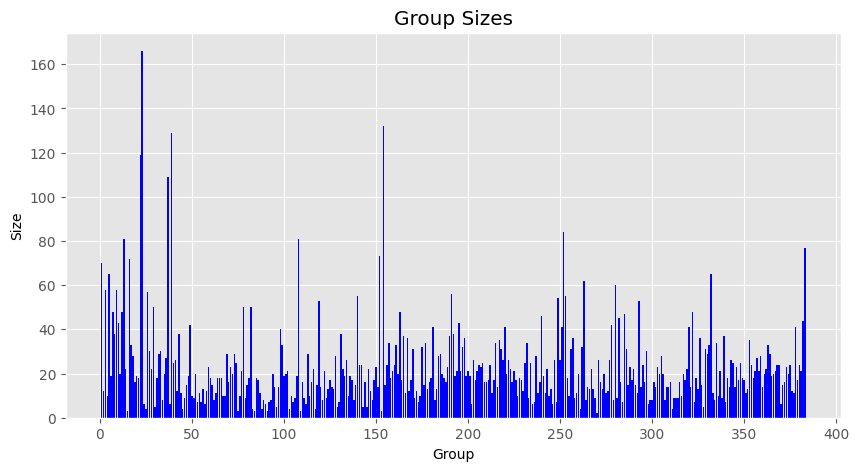

In [15]:
# Group columns by cluster
df = pd.DataFrame(corr_matrix)
df.columns = ['col_' + str(i) for i in range(df.shape[1])]
df['cluster'] = clusters
grouped = df.groupby('cluster')

# Get the size of each group
group_sizes = grouped.size()

# Plot the group sizes
plt.figure(figsize=(10,5))
plt.bar(x=group_sizes.index, height=group_sizes.values, color='blue')
plt.title('Group Sizes')
plt.xlabel('Group')
plt.ylabel('Size')
plt.show()

In [16]:
print(Y.shape)
print(X.shape)
print(len(clusters))

(103, 5)
(103, 8747)
8747


In [17]:
# Step 3: Calculate the correlation matrix between the columns of X and the columns of Y
corr_matrix = np.abs(np.corrcoef(X.T, Y.T)[:X.shape[1], X.shape[1]:])

# compute the row-wise averages of the matrix
avg_matrix = np.mean(corr_matrix, axis=1, keepdims=True)

# concatenate the average matrix with the group array
concat_matrix = np.concatenate([avg_matrix, clusters.reshape(len(clusters), 1)], axis=1)

# sort the concatenated matrix by group
sorted_matrix = concat_matrix[concat_matrix[:, -1].argsort()]

# find the maximum value in each group and its index
max_values = []
# iterate over the unique groups in the second column of the sorted matrix
for group in np.unique(sorted_matrix[:, 1]):
    # find the indices of rows that belong to the current group
    indices = np.where(sorted_matrix[:, 1] == group)[0]
    # get the maximum value in the first column for the current group
    max_value = np.max(sorted_matrix[indices, 0])
    # append the maximum value to the list
    max_values.append(max_value)
    
    
# find the indices of all the maximum values in the avg_matrix
max_indices = []
for max_value in max_values:
    indices = np.where(avg_matrix == max_value)[0]
    max_indices.extend(indices)

X_filtered = X.iloc[:, max_indices]
print(X_filtered.shape)



(103, 386)


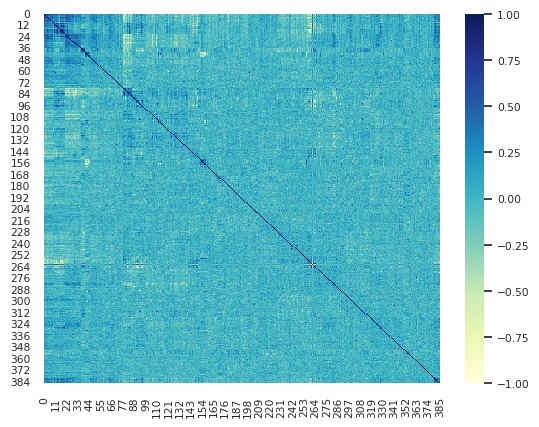

In [18]:
plot_correlation_matrix(X_filtered)

In [19]:
# def get_selected_voting_features_multi(Y, X_filtered, filter_methods, k):
#     feature_counts = np.zeros(X_filtered.shape[1])
    
#     #print(Y.shape[1])
#     print(len(Y.T))
    
#     for i in range(len(Y.T)):
#         y_i = Y.iloc[:, i]
        
#         for method_name, method in filter_methods.items():
#             pipeline = Pipeline([(method_name, method), ('regressor', LinearRegression())])
#             pipeline.fit(X_filtered, y_i)
#             selected_i = pipeline.named_steps[method_name].get_support(indices=True)
            
#             # Increment the count for each selected feature
#             for index in selected_i:
#                 feature_counts[index] += 1
                
#     # Get the indices of the top k features with the most counts
#     top_k_features = np.argsort(feature_counts)[-k:]
    
#     return top_k_features

In [20]:
# filter_methods = {
#     'f_regression': SelectKBest(f_regression, k=10),
#     'mutual_info_regression': SelectKBest(mutual_info_regression, k=10),
#     'variance_threshold': VarianceThreshold(threshold=0.1),
# }

# all_selected_features = get_selected_voting_features_multi(Y, X_filtered, filter_methods, k=15)

# print("Fused selected features:", all_selected_features)


In [21]:
# X_final = X_filtered.iloc[:, list(set(all_selected_features))]
# plot_correlation_matrix(X_final)
# column_names = X_final.columns.tolist()
# print(column_names)

In [22]:
# models_to_drop = ["MLPRegressor", "KNeighborsRegressor", "DecisionTreeRegressor", "GradientBoostingRegressor", "SVR"]

# for name in models_to_drop:
#     for i in range(len(MODELS)):
#         if MODELS[i]["name"] == name:
#             del MODELS[i]
#             break
        
# for model in MODELS:
#     print(model["name"])

In [23]:
# # Runs in ~5 min for n_fols=5
# search = HyperparaSearch(models=MODELS, metrics=["mean_absolute_error"], n_folds=5, n_jobs=-1)

# results = search.run(X_final, Y, save=False)

In [24]:
# best_feats_dict = {model[0]['name']: model[0]['best_feats'] for model in results}
# #print(best_feats_dict)

In [25]:
# for model in best_feats_dict.keys():
#     print(f"Algorithm: {model}")
#     # Get the feature importance values for the algorithm
#     feat_imp_vals = best_feats_dict[model]
#     # Map the feature importance values with the feature list using a dictionary comprehension
#     feat_imp_map = {column_names[i]: feat_imp_vals[i] for i in range(len(column_names))}
#     # Rank the features by their importance value in descending order
#     ranked_feats = sorted(feat_imp_map.items(), key=lambda x: x[1], reverse=True)
#     # Print the ranked features
#     #print(ranked_feats)

In [26]:
# eval_metric = "mean_absolute_error"

# # Plot the results
# mae_scores = [
#     rd["score"]
#     for result_list in results
#     for rd in result_list
#     if rd["metric"] == eval_metric
# ]
# model_names = [
#     rd["name"]
#     for result_list in results
#     for rd in result_list
#     if rd["metric"] == eval_metric
# ]
# plt.bar(model_names, mae_scores)
# plt.title("Mean Absolute Error Scores")
# plt.xlabel("Model")
# plt.ylabel("Score")
# plt.xticks(rotation=45) 
# plt.show()

In [27]:
# Print the model with the lowest score
# best_model = min(
#     [
#         min(
#             sublist,
#             key=lambda x: x["score"]
#             if x["metric"] == eval_metric
#             else float("inf"),
#         )
#         for sublist in results
#     ],
#     key=lambda x: x["score"],
# )
# print(f"Best model: {best_model['name']}")
# print(f"Best params: {best_model['params']}")
# print(f"Best Score: {best_model['score']}")

In [28]:
def get_selected_voting_features_uni(Y, X_filtered, filter_methods, k):
    np.random.seed(42) 
    
    feature_counts = np.zeros(X_filtered.shape[1])
        
    for method_name, method in filter_methods.items():
        pipeline = Pipeline([(method_name, method), ('regressor', LinearRegression())])
        pipeline.fit(X_filtered, Y)
        selected_i = pipeline.named_steps[method_name].get_support(indices=True)
        
        # Increment the count for each selected feature
        for index in selected_i:
            feature_counts[index] += 1
                
    # Get the indices of the top k features with the most counts
    top_k_features = np.argsort(feature_counts)[-k:]
    
    return top_k_features

In [29]:
# Create a dictionary for each PERMA pillar
perma_dict = {
    "P": None,
    "E": None,
    "R": None,
    "M": None,
    "A": None,
}

filter_methods = {
    'f_regression': SelectKBest(f_regression, k=10),
    'mutual_info_regression': SelectKBest(mutual_info_regression, k=10),
    'variance_threshold': VarianceThreshold(threshold=0.1),
}

# Iterate over each PERMA dimension in Y
for i, perma_dim in enumerate(Y.columns):
    # Get the selected features for the current PERMA dimension
    selected_features = get_selected_voting_features_uni(Y.iloc[:, i], X_filtered, filter_methods, k=10)
    # Save the selected features in the corresponding dictionary for the current PERMA pillar
    perma_dict[perma_dim] = selected_features

# Print the selected features for each PERMA dimension in each PERMA pillar
for pillar in perma_dict:
    print(pillar, ":", perma_dict[pillar])


P : [373 190 346 158 350 182 324 354 374 115]
E : [ 27  51 273 107 326 337 324 158 233 104]
R : [ 23  25 268 164 189 148 318  21 303 135]
M : [  6 118 155  49 195 196 207 346  69  54]
A : [  5   6 161  10 363 102 365 324 115 122]


In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X_filtered, Y, test_size=0.2, random_state=42)

In [31]:
feature_sets = {
    "P": {"train": None, "test": None},
    "E": {"train": None, "test": None},
    "R": {"train": None, "test": None},
    "M": {"train": None, "test": None},
    "A": {"train": None, "test": None}
}

for perma_dim, selected_features in perma_dict.items():
    # Select the corresponding columns of X_filtered
    X_train_final = X_train.iloc[:, list(set(selected_features))]
    X_test_final = X_test.iloc[:, list(set(selected_features))]
    # Add the selected features for the current PERMA dimension to the feature sets dictionary
    feature_sets[perma_dim]["train"] = X_train_final
    feature_sets[perma_dim]["test"] = X_test_final
    # Print the names of the selected features
    column_names = X_train_final.columns.tolist()
    print(perma_dim, ":", column_names)

P : ['Sad__fft_coefficient__attr_"real"__coeff_96', 'Fear__fft_coefficient__attr_"angle"__coeff_2', 'Neutral__fft_coefficient__attr_"angle"__coeff_80', 'Valence__fft_coefficient__attr_"angle"__coeff_5', 'Brightness__fft_coefficient__attr_"imag"__coeff_96', 'Surprise__fft_coefficient__attr_"angle"__coeff_23', 'Disgust__fft_coefficient__attr_"imag"__coeff_4', 'Disgust__fft_coefficient__attr_"real"__coeff_12', 'Neutral__fft_coefficient__attr_"angle"__coeff_84', 'Valence__fft_coefficient__attr_"angle"__coeff_14']
E : ['Fear__fft_coefficient__attr_"angle"__coeff_2', 'Surprise__fft_coefficient__attr_"imag"__coeff_15', 'Arousal__fft_coefficient__attr_"imag"__coeff_12', 'Fear__fft_coefficient__attr_"real"__coeff_4', 'Brightness__fft_coefficient__attr_"imag"__coeff_28', 'Dominance__fft_coefficient__attr_"real"__coeff_78', 'Arousal__fft_coefficient__attr_"angle"__coeff_12', 'Dominance__fft_coefficient__attr_"abs"__coeff_71', 'Brightness__fft_coefficient__attr_"abs"__coeff_45', 'Disgust__fft_coef

In [32]:
SAVE_DIR = Path("/home/moritz/Workspace/masterthesis/model/custom_models/univariate/big")

eval_metric = "mean_absolute_error"

In [33]:
models_to_drop = ["MLPRegressor", "KNeighborsRegressor", "DecisionTreeRegressor", "SVR"]

for name in models_to_drop:
    for i in range(len(MODELS)):
        if MODELS[i]["name"] == name:
            del MODELS[i]
            break
        
for model in MODELS:
    print(model["name"])

RandomForestRegressor
ExtraTreesRegressor
GradientBoostingRegressor
AdaBoostRegressor
LinearRegression
Ridge
Lasso
ElasticNet
BayesianRidge
CatBoostRegressor
XGBRegressor


In [34]:
results_dict = {}

for perma_dim, X_final in feature_sets.items():
    print(f"PERMA dimension: {perma_dim}")
    # Run the hyperparameter search
    models_path = SAVE_DIR / perma_dim
    search = HyperparaSearch(models=MODELS, metrics=["mean_absolute_error"], models_path = models_path, n_folds=5, n_jobs=-1, mode="uni")
    results = search.run(X_final["train"], Y_train[perma_dim], save=True)
    results_dict[perma_dim] = results
    # Print the model with the lowest score
    best_model = min(
        [
            min(
                sublist,
                key=lambda x: x["score"]
                if x["metric"] == eval_metric
                else float("inf"),
            )
            for sublist in results
        ],
        key=lambda x: x["score"],
    )
    print(perma_dim)
    print(f"Best model: {best_model['name']}")
    print(f"Best params: {best_model['params']}")
    print(f"Best Score: {best_model['score']}")

PERMA dimension: P
Models for RandomForestRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/P/RandomForestRegressor.joblib
Models for ExtraTreesRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/P/ExtraTreesRegressor.joblib
Models for GradientBoostingRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/P/GradientBoostingRegressor.joblib
Models for AdaBoostRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/P/AdaBoostRegressor.joblib
Models for LinearRegression saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/P/LinearRegression.joblib
Models for Ridge saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/P/Ridge.joblib
Models for Lasso saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/P/Lasso.joblib
Models for ElasticNet saved to /home/moritz/Workspa

In [35]:
perma_models = {}

for perma_dim in ["P", "E", "R", "M", "A"]:
    models_path = SAVE_DIR / perma_dim
    models = load_models(models_path)
    perma_models[perma_dim] = models

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def generate_predictions(models, X, y):
    # Generate and return a dictionary of mean absolute error (MAE) scores and prediction arrays for each model
    results = {}
    for model_name, mae_grid_search in models.items():
        # Fit the model
        model = mae_grid_search[0].best_estimator_
        # Make predictions
        y_pred = model.predict(X)
        # Calculate mean squared error and mean absolute error
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        results[model_name] = {"mae": mae, "mse": mse, "y_pred": y_pred}
    return results

In [37]:
perma_results = {}

for dim, models in perma_models.items():
    X_test = feature_sets[dim]["test"]
    results = generate_predictions(models, X_test, Y_test[dim])
    perma_results[dim] = results
    # for model_name, result in results.items():
    #     print(f"{dim} - {model_name}: MAE - {result['mae']}, MSE - {result['mse']}")
    

In [38]:
best_results = {}

for dim, results in perma_results.items():
    curr_mae = float("inf")
    for model in results:
        if results[model]["mae"] < curr_mae:
            curr_mae = results[model]["mae"]
            best_results[dim] = {"model": model, "mae": results[model]["mae"], "preds": results[model]["y_pred"]}
            
print(best_results)

{'P': {'model': 'BayesianRidge', 'mae': 0.14342003582653604, 'preds': array([0.60033404, 0.74157572, 0.67817996, 0.69309962, 0.59775043,
       0.36808938, 0.58253212, 0.7364104 , 0.83951841, 0.68495   ,
       0.37795894, 0.60376776, 0.71643643, 0.66287078, 0.66216868,
       0.67784146, 0.70856167, 0.67534087, 0.83099299, 0.63841265,
       0.69796421])}, 'E': {'model': 'BayesianRidge', 'mae': 0.16467305025598206, 'preds': array([0.54230833, 0.72153148, 0.36776633, 0.70981582, 0.76720949,
       0.51427536, 0.60331182, 0.72138073, 0.52621074, 0.6887484 ,
       0.35988336, 0.5035934 , 0.63022907, 0.60018041, 0.63223312,
       0.59110645, 0.71810856, 0.55631318, 0.70316311, 0.60991061,
       0.58296442])}, 'R': {'model': 'GradientBoostingRegressor', 'mae': 0.1300850585734667, 'preds': array([0.74265647, 0.76856417, 0.74455078, 0.72474918, 0.76139998,
       0.76360009, 0.81368056, 0.81960848, 0.79829862, 0.76139998,
       0.72726188, 0.75314174, 0.76856417, 0.54463685, 0.76020401,


In [39]:
best_feats_dict = {}

for dim, results in results_dict.items():
    best_feats_dict[dim] = {model[0]['name']: {"feat_imp": model[0]['best_feats'], "score": model[0]["score"]}  for model in results}

best_feats_dict_dim = {}
    
for dim in ['P', 'E', 'R', 'M', 'A']:
    model = best_results[dim]["model"]
    feat_imp = abs(best_feats_dict[dim][model]["feat_imp"])
    best_feats_dict_dim[dim] = feat_imp

best_feats_dict_dim

{'P': array([4.99893662e-05, 3.97851660e-04, 4.81050688e-04, 4.26557477e-05,
        2.00567024e-06, 4.20098281e-04, 1.84864346e-04, 5.22161042e-04,
        5.94942800e-05, 1.45138303e-04]),
 'E': array([1.85993938e-04, 3.14608689e-04, 7.67526250e-06, 4.44690374e-04,
        5.55746931e-06, 1.46226755e-04, 7.17119972e-05, 1.85047766e-04,
        1.39495802e-05, 3.61087359e-04]),
 'R': array([0.00231181, 0.03506668, 0.14082152, 0.11092169, 0.00879218,
        0.05725962, 0.17773263, 0.02438192, 0.36451837, 0.07819357]),
 'M': array([9.16162401e-04, 3.37385370e-04, 9.75626040e-04, 1.06712417e-04,
        3.94504084e-05, 1.87920480e-03, 6.05073945e-04, 2.28110680e-06,
        3.92707804e-04, 1.18674711e-07]),
 'A': array([7.85500396e-06, 2.69843750e-04, 1.67509886e-04, 1.47499371e-04,
        3.98724352e-04, 5.44852263e-06, 4.25255233e-05, 2.70754531e-04,
        4.23464531e-04, 4.46679050e-04])}

In [40]:
ranked_feats_dict = {}

for (dim, feat_imp_vals), (dim, X_final) in zip(best_feats_dict_dim.items(), feature_sets.items()):
    # Map the feature importance values with the feature list using a dictionary comprehension
    column_names = X_final["train"].columns.tolist()
    feat_imp_map = {column_names[i]: feat_imp_vals[i] for i in range(len(column_names))}
    # Rank the features by their importance value in descending order
    ranked_feats = sorted(feat_imp_map.items(), key=lambda x: x[1], reverse=True)
    ranked_feats_dict[dim] = ranked_feats

/tmp/ipykernel_772271/4206057206.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')


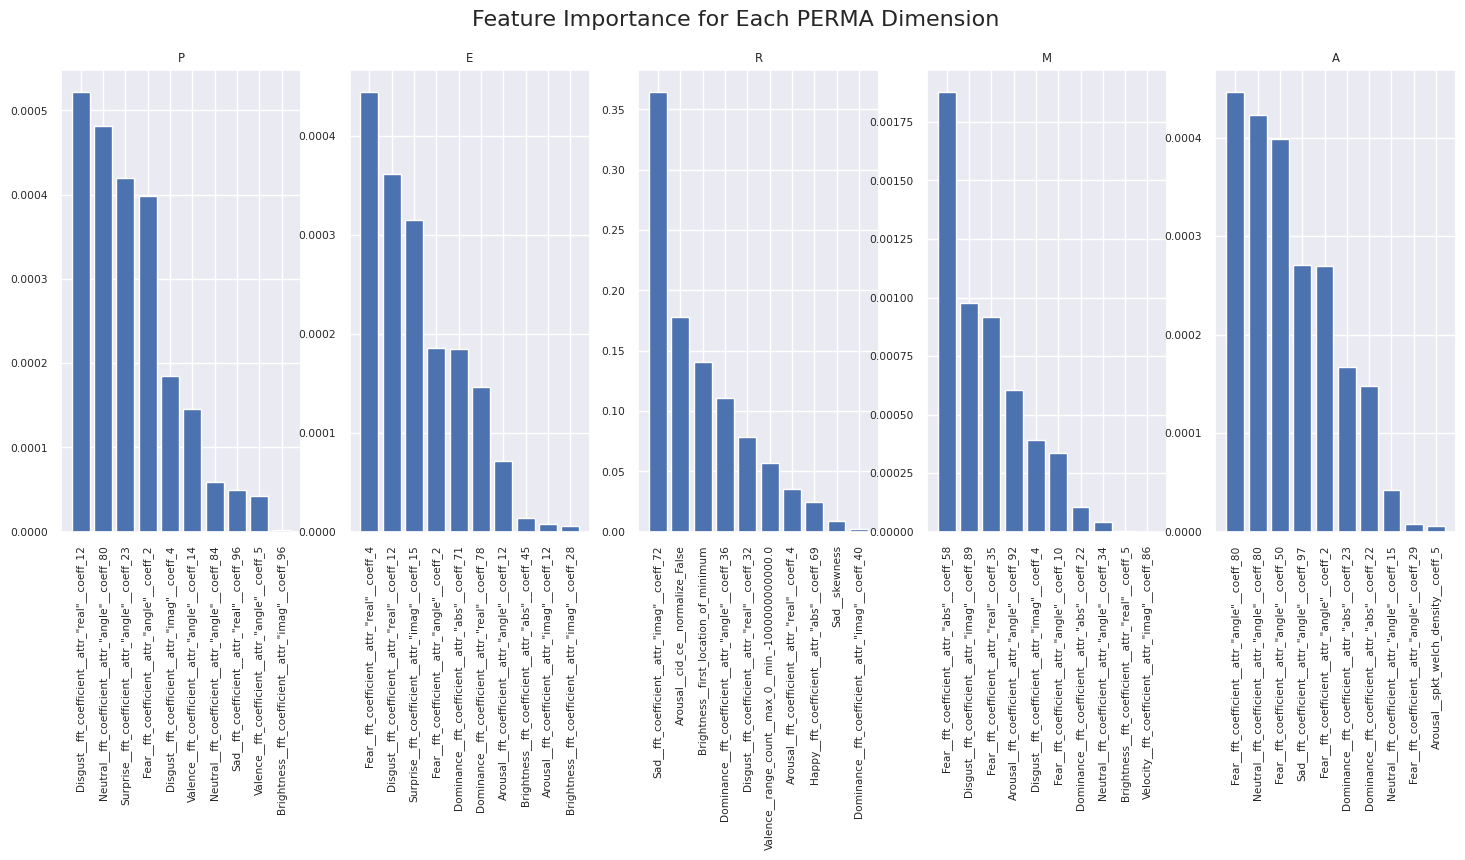

In [41]:
#Separate the feature names and importance scores for each dimension PERMA
P_features, P_scores = zip(*ranked_feats_dict["P"])
E_features, E_scores = zip(*ranked_feats_dict["E"])
R_features, R_scores = zip(*ranked_feats_dict["R"])
M_features, M_scores = zip(*ranked_feats_dict["M"])
A_features, A_scores = zip(*ranked_feats_dict["A"])


#Create a bar plot for each dimension PERMA
fig, axs = plt.subplots(1, 5, figsize=(18, 6))
axs[0].bar(P_features, P_scores)
axs[0].set_title("P")
axs[1].bar(E_features, E_scores)
axs[1].set_title("E")
axs[2].bar(R_features, R_scores)
axs[2].set_title("R")
axs[3].bar(M_features, M_scores)
axs[3].set_title("M")
axs[4].bar(A_features, A_scores)
axs[4].set_title("A")

#Set common axis labels and title
fig.suptitle("Feature Importance for Each PERMA Dimension", fontsize=16)
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')

In [42]:
# Baseline:
Y_baseline = np.full_like(Y_test, Y_test.mean(axis=0).transpose())
mae_baseline = mean_absolute_error(Y_test, Y_baseline, multioutput='raw_values')

print(f"Baseline MAE for each dimension: {mae_baseline}")

Baseline MAE for each dimension: [0.16439909 0.20816327 0.14739229 0.20272109 0.1462585 ]


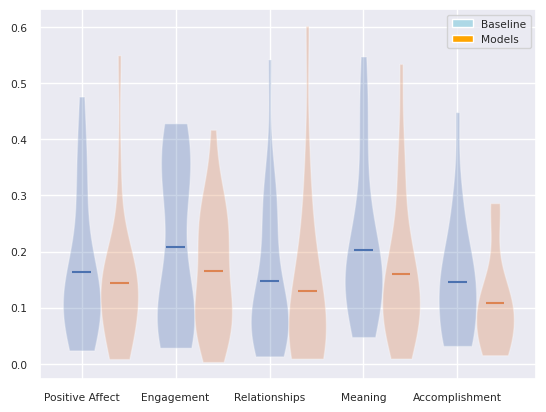

In [43]:
# Calculate the errors between the actual values and the baseline predictions
baseline_errors = abs(Y_test - Y_baseline)

# Calculate the errors for each model and each dimension
model_errors = pd.DataFrame()

# Calculate the errors for each model and each dimension
for dim in ['P', 'E', 'R', 'M', 'A']:
    err = abs(Y_test[dim] - best_results[dim]['preds'])
    errors = pd.DataFrame({'errors': err})
    model_errors = pd.concat([model_errors, errors], axis=1)

# Concatenate baseline and model errors
all_errors = [baseline_errors, model_errors]

# Create a combined boxplot
fig, ax = plt.subplots()
colors = ['lightblue', 'orange']
labels = ['Baseline', 'Models']

for i, error_df in enumerate(all_errors):
    position = np.arange(1, len(error_df.columns) + 1) + (i * 0.4)
    #ax.boxplot(error_df, positions=position, widths=0.4, patch_artist=True, boxprops=dict(facecolor=colors[i]), medianprops=dict(color='black'))
    ax.violinplot(error_df, positions=position, widths=0.4, showmedians=False, showextrema=False, showmeans=True)

# Define the labels for the x-axis
perma = ['Positive Affect', 'Engagement', 'Relationships', 'Meaning', 'Accomplishment']

# Set the x-axis ticks and labels
ax.set_xticks(np.arange(1, len(perma) + 1))
ax.set_xticklabels(perma)

# Create the legend patches and labels
patches = [mpatches.Patch(facecolor=color, label=label) for color, label in zip(colors, labels)]

# Add the legend to the plot
ax.legend(handles=patches, loc='upper right')

Text(0.5, 1.0, 'PERMA Dimension MAE Scores')

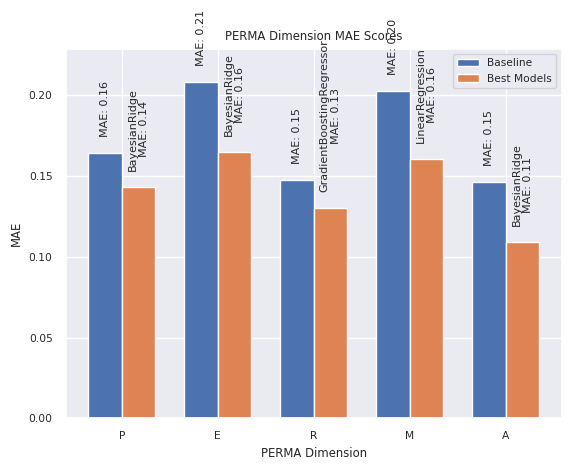

In [44]:
# Print the best model for each PERMA dimension
best_mae_values = [v['mae'] for v in best_results.values()]

# Define the x-axis labels and the bar width
perma_dimensions = ['P', 'E', 'R', 'M', 'A']
bar_width = 0.35

# Set up the plot
fig, ax = plt.subplots()
ax.bar(np.arange(len(perma_dimensions)), mae_baseline, width=bar_width, label='Baseline')
ax.bar(np.arange(len(perma_dimensions))+bar_width, best_mae_values, width=bar_width, label='Best Models')

# Set the x-axis ticks and labels
ax.set_xticks(np.arange(len(perma_dimensions))+bar_width/2)
ax.set_xticklabels(perma_dimensions)
ax.set_xlabel('PERMA Dimension')

# Set the y-axis label and limits
ax.set_ylabel('MAE')
ax.set_ylim([0, max(np.max(mae_baseline), np.max(best_mae_values))*1.1])

# Add the model names and MAE values above each bar
for i, v in enumerate(mae_baseline):
    ax.text(i, v+0.01, f"MAE: {v:.2f}", rotation=90, ha='center', va='bottom', fontsize=8)
    ax.text(i+bar_width, best_mae_values[i]+0.01, f"{best_results[perma_dimensions[i]]['model']}\nMAE: {best_mae_values[i]:.2f}", rotation=90, ha='center', va='bottom', fontsize=8)

# Add a legend and title
ax.legend()
ax.set_title('PERMA Dimension MAE Scores')

In [128]:
Y_pred = pd.DataFrame()

for dim in ['P', 'E', 'R', 'M', 'A']:
    err = best_results[dim]['preds']
    errors = pd.DataFrame({dim: err})
    Y_pred = pd.concat([Y_pred, errors], axis=1)

# Unscale the data back to the original scale
Y_preds = pd.DataFrame(minmax_scaler.inverse_transform(Y_pred), columns=['P', 'E', 'R', 'M', 'A'])
Y_tests = pd.DataFrame(minmax_scaler.inverse_transform(Y_test), columns=['P', 'E', 'R', 'M', 'A'])
Y_baselines = pd.DataFrame(minmax_scaler.inverse_transform(Y_baseline), columns=['P', 'E', 'R', 'M', 'A'])

In [129]:
Y_baseline_df = pd.DataFrame(Y_baseline, columns=['P', 'E', 'R', 'M', 'A'])

print(Y_pred.min())
print(Y_pred.max())
print(Y_test.min())
print(Y_test.max())

P    0.368089
E    0.359883
R    0.544637
M    0.037492
A    0.520843
dtype: float64
P    0.839518
E    0.767209
R    0.819608
M    0.844140
A    0.951907
dtype: float64
P    0.166667
E    0.200000
R    0.166667
M    0.000000
A    0.250000
dtype: float64
P    1.0
E    1.0
R    1.0
M    1.0
A    1.0
dtype: float64


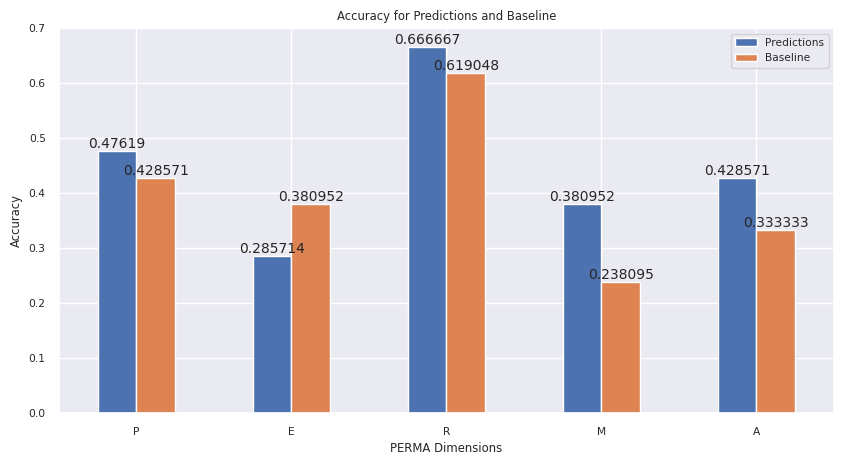

In [163]:
# Define the bins and labels
bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']

# Apply the binning
actual_values_bins = Y_test.apply(pd.cut, bins=bins, labels=labels)
predictions_bins = Y_pred.apply(pd.cut, bins=bins, labels=labels)
baseline_bins = Y_baseline_df.apply(pd.cut, bins=bins, labels=labels)

# Reset the indices of both DataFrames
actual_values_bins.reset_index(drop=True, inplace=True)
predictions_bins.reset_index(drop=True, inplace=True)
baseline_bins.reset_index(drop=True, inplace=True)

# Calculate the accuracy for each column
accur_preds = (actual_values_bins == predictions_bins).mean()
accur_baseline = (actual_values_bins == baseline_bins).mean()

# Combine accuracy values into a single DataFrame
accuracy_df = pd.DataFrame({'Predictions': accur_preds, 'Baseline': accur_baseline})

# Plot the accuracy values for predictions and baseline
ax = accuracy_df.plot(kind='bar', figsize=(10, 5))
plt.title('Accuracy for Predictions and Baseline')
plt.xlabel('PERMA Dimensions')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.legend()

# Annotate values on top of the bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)



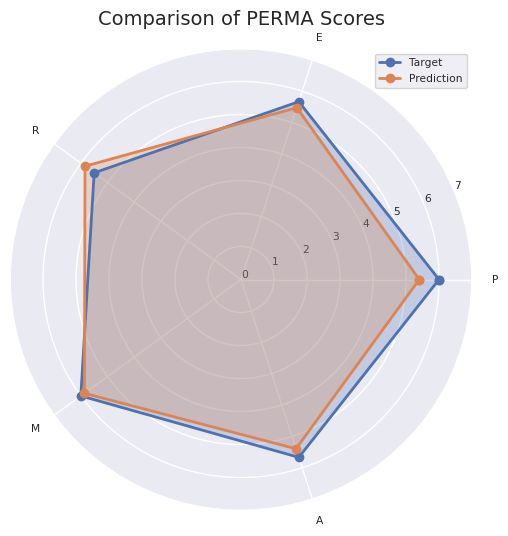

In [91]:
# Define the labels for the radar plots
labels = ['P', 'E', 'R', 'M', 'A']

# Create the figure and subplot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, polar=True)

# Loop over each row of Y_tests and Y_preds
for i in [np.random.randint(0, len(Y_tests))]:
    # Define the data for the radar plot
    data1 = Y_tests.iloc[i].values
    data2 = Y_preds.iloc[i].values
    #data3 = Y_baselines.iloc[i].values

    # Define the angle for each label
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)

    # Close the plot
    data1 = np.concatenate((data1, [data1[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    data2 = np.concatenate((data2, [data2[0]]))
    #data3 = np.concatenate((data3, [data3[0]]))

    # Plot the radar plot
    ax.plot(angles, data1, 'o-', linewidth=2, label=f'Target')
    ax.fill(angles, data1, alpha=0.25)
    ax.plot(angles, data2, 'o-', linewidth=2, label=f'Prediction')
    ax.fill(angles, data2, alpha=0.25)
    #ax.plot(angles, data3, 'o-', linewidth=2, label=f'Baseline')
    #ax.fill(angles, data3, alpha=0.25)

# Set the labels
ax.set_thetagrids(angles[:-1] * 180/np.pi, labels)
plt.yticks(np.arange(0, 7.1, 1.0))
plt.ylim(0, 7)
plt.title('Comparison of PERMA Scores', fontsize=14)
plt.legend()